In [1]:
from cute_viz import display_tv_layout
import torch
from functools import partial
from typing import List

import cutlass
import cutlass.cute as cute
from cutlass.cute.runtime import from_dlpack
from cutlass.cute import KeepPTX, KeepCUBIN
import cupy as cp
from cutlass.torch import dtype as torch_dtype
import cutlass.cute.runtime as cute_rt

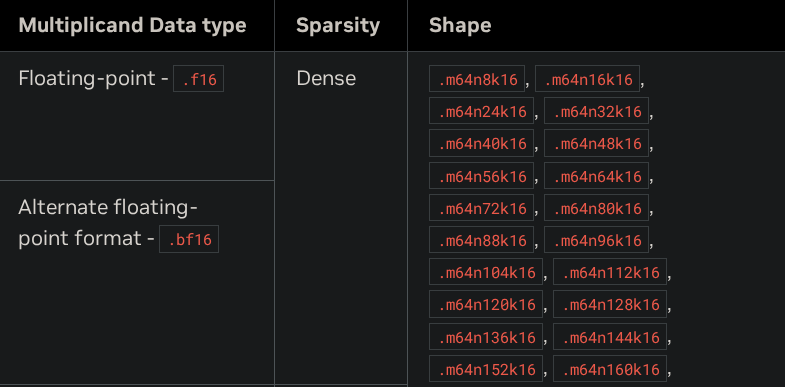


indeed we are dealing with .bf16, f32 accumulator, and we have problem shape (64,N,16)
so what is the layout of register fragments for A? well A shape is fixed at (64,16) so only one way to do it
also we have warp group, so 4 warps, lets see. 
at the granularity of warpgroup (see picture below) for A matrix, each warp holds a 16,16 chunk 
so imagine my layout is A = (64,16):(16,1) (row major) then we need to tile it with the layout (4:1)



In [ ]:
@cute.jit
def warp_tile(): 
  A_layout = cute.make_layout((64,16), stride = (16,1))
  warp_group_shape = (4,)
  warp_tiled_A = cute.zipped_divide(A_layout, warp_group_shape)
  cute.printf(warp_tiled_A)
  

In [5]:
warp_tile()

((4),(16,16)):((16),(64,1))


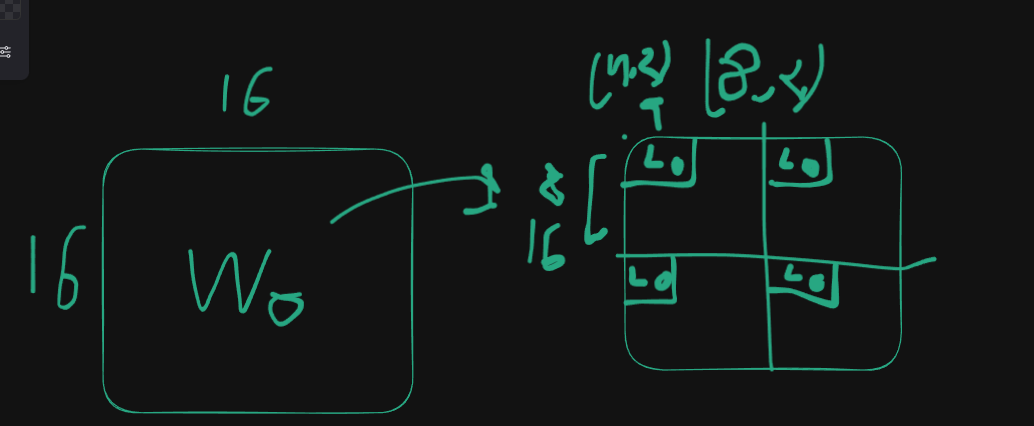

In [ ]:
@cute.jit
def make_bf16x2_layout(): 
  A_layout = cute.make_layout((64,16), stride = (16,1))
  bf16x2_vector_shape = (1,2)
  A_bf16x2_layout = cute.zipped_divide(A_layout, bf16x2_vector_shape)
  cute.printf(A_bf16x2_layout)
  #we need to check if our layout is continous 
  for row in range(64):
    for col in range(8): 
      c_left = ((0),(row,col))
      c_right = ((1),(row,col))
      A_left = A_bf16x2_layout(c_left)
      A_right = A_bf16x2_layout(c_right)
      cute.printf(A_left)
      cute.printf(A_right)
      
  #next, we need to make an axis (lane_id), (layout_rest) which for each lane id, 

In [ ]:
make_bf16x2_layout() #okay so this layout is contigous. 

((1,2),(64,8)):((0,1),(16,2))
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269


In [ ]:
"""
BUT WE ARE MAKING A MISTAKE IN THE ORDER IN WHICH WE ARE TILING, let us look at what zipped divide does 
by understanding it carefully. 


"""

In [70]:
n_elems = 16*16
X = torch.arange(n_elems, dtype=torch_dtype(cutlass.Float16)) 
X_ptr = cute_rt.make_ptr(cutlass.Float16, X.data_ptr())

@cute.jit
def zipper_divider(pointer:cute.Pointer):
  L = cute.make_layout((16,16), stride = (1,16))
  zip_shape = (4,4)
  L_tiled = cute.zipped_divide(L, zip_shape)
  cute.printf(L_tiled)

  tensor = cute.make_tensor(pointer, L_tiled)
  slice = ((None), (0,0))
  cute.print_tensor(tensor[slice],verbose=True) 
  
  

In [71]:
zipper_divider(X_ptr)

((4,4),(4,4)):((1,16),(4,64))
tensor(raw_ptr(0x000055568dd35340: f16, generic, align<2>) o ((4,4)):((1,16)), data= (
	((0,0))= 0.000000
	((1,0))= 1.000000
	((2,0))= 2.000000
	((3,0))= 3.000000
	((0,1))= 16.000000
	((1,1))= 17.000000
	((2,1))= 18.000000
	((3,1))= 19.000000
	((0,2))= 32.000000
	((1,2))= 33.000000
	((2,2))= 34.000000
	((3,2))= 35.000000
	((0,3))= 48.000000
	((1,3))= 49.000000
	((2,3))= 50.000000
	((3,3))= 51.000000
)


In [75]:
print(X.reshape(16,16).T.numpy())

[[  0.  16.  32.  48.  64.  80.  96. 112. 128. 144. 160. 176. 192. 208.
  224. 240.]
 [  1.  17.  33.  49.  65.  81.  97. 113. 129. 145. 161. 177. 193. 209.
  225. 241.]
 [  2.  18.  34.  50.  66.  82.  98. 114. 130. 146. 162. 178. 194. 210.
  226. 242.]
 [  3.  19.  35.  51.  67.  83.  99. 115. 131. 147. 163. 179. 195. 211.
  227. 243.]
 [  4.  20.  36.  52.  68.  84. 100. 116. 132. 148. 164. 180. 196. 212.
  228. 244.]
 [  5.  21.  37.  53.  69.  85. 101. 117. 133. 149. 165. 181. 197. 213.
  229. 245.]
 [  6.  22.  38.  54.  70.  86. 102. 118. 134. 150. 166. 182. 198. 214.
  230. 246.]
 [  7.  23.  39.  55.  71.  87. 103. 119. 135. 151. 167. 183. 199. 215.
  231. 247.]
 [  8.  24.  40.  56.  72.  88. 104. 120. 136. 152. 168. 184. 200. 216.
  232. 248.]
 [  9.  25.  41.  57.  73.  89. 105. 121. 137. 153. 169. 185. 201. 217.
  233. 249.]
 [ 10.  26.  42.  58.  74.  90. 106. 122. 138. 154. 170. 186. 202. 218.
  234. 250.]
 [ 11.  27.  43.  59.  75.  91. 107. 123. 139. 155. 171. 187. 203

In [ ]:
"""
so as you can see, zipped_divide((M,N):(,), (TM,TN))
has the following rules 
for any layout L, it applies the zipped divide to the outermost mode so to speak. 
and what we get is is a layout that looks like L_tiled = ((inner_mode), (outer_mode))
in the sense that the leftmost mode (mode0/inner_mode) is at element granulairity, whereas, 
"""

In [95]:
n_elems = 16*16
X = torch.arange(n_elems, dtype=torch_dtype(cutlass.Float16)) 
X_ptr = cute_rt.make_ptr(cutlass.Float16, X.data_ptr())

@cute.jit
def zipper_divider(pointer:cute.Pointer):
  L = cute.make_layout((256,))
  cute.printf(L)
  zip_shape = (16,)
  L_tiled = cute.zipped_divide(L, zip_shape)
  cute.printf(L_tiled)

  tensor = cute.make_tensor(pointer, L_tiled)
  cute.print_tensor(tensor,verbose=True) 
  
  

In [96]:
zipper_divider(X_ptr)

(256):(1)
((16),(16)):((1),(16))
tensor(raw_ptr(0x000055568f33f9c0: f16, generic, align<2>) o ((16),(16)):((1),(16)), data= (
	((0),(0))= 0.000000
	((1),(0))= 1.000000
	((2),(0))= 2.000000
	((3),(0))= 3.000000
	((4),(0))= 4.000000
	((5),(0))= 5.000000
	((6),(0))= 6.000000
	((7),(0))= 7.000000
	((8),(0))= 8.000000
	((9),(0))= 9.000000
	((10),(0))= 10.000000
	((11),(0))= 11.000000
	((12),(0))= 12.000000
	((13),(0))= 13.000000
	((14),(0))= 14.000000
	((15),(0))= 15.000000
	((0),(1))= 16.000000
	((1),(1))= 17.000000
	((2),(1))= 18.000000
	((3),(1))= 19.000000
	((4),(1))= 20.000000
	((5),(1))= 21.000000
	((6),(1))= 22.000000
	((7),(1))= 23.000000
	((8),(1))= 24.000000
	((9),(1))= 25.000000
	((10),(1))= 26.000000
	((11),(1))= 27.000000
	((12),(1))= 28.000000
	((13),(1))= 29.000000
	((14),(1))= 30.000000
	((15),(1))= 31.000000
	((0),(2))= 32.000000
	((1),(2))= 33.000000
	((2),(2))= 34.000000
	((3),(2))= 35.000000
	((4),(2))= 36.000000
	((5),(2))= 37.000000
	((6),(2))= 38.000000
	((7),(2))= 39

In [ ]:
"""
looking at this we can clearly make some ideas work              
                                            <-- (TM,TN),(M//TM, N//TN)       <--(M,N)
just notice that the element level chunk is gonna be on the left so we need to start tiling top to bottom not the 
other way up 
so the first level of tiling is going tu turn A: (64,16) to A_tiled (16,16), (4,1) so the warp_id  mode is last. 

"""



'\nlooking at this we can clearly make some ideas work              \n                                            <-- (TM,TN),(M//TM, N//TN)       <--(M,N)\njust notice that the element level chunk is gonna be on the left \n\n'

In [125]:
A_tensor = torch.arange(16*64, dtype=torch_dtype(cutlass.Float16))
A_ptr = cute_rt.make_ptr(cutlass.Float16, A_tensor.data_ptr())
@cute.jit
def warp_tiler(pointer:cute.Pointer):
  element_L = cute.make_layout((16,64), stride = (1,16)) #column major A, we dont really give a fuck though stride is guuci 
  warp_tile = cute.make_layout((16,16), stride=(1,16))
  element_warp_L = cute.zipped_divide(element_L, warp_tile)
  cute.printf(element_warp_L)
  T = cute.make_tensor(pointer, element_warp_L)
  cute.print_tensor(T, verbose=True)

In [126]:
warp_tiler(A_ptr)

((16,16),4):((1,16),256)
tensor(raw_ptr(0x0000555690ab0dc0: f16, generic, align<2>) o ((16,16),4):((1,16),256), data= (
	((0,0),0)= 0.000000
	((1,0),0)= 1.000000
	((2,0),0)= 2.000000
	((3,0),0)= 3.000000
	((4,0),0)= 4.000000
	((5,0),0)= 5.000000
	((6,0),0)= 6.000000
	((7,0),0)= 7.000000
	((8,0),0)= 8.000000
	((9,0),0)= 9.000000
	((10,0),0)= 10.000000
	((11,0),0)= 11.000000
	((12,0),0)= 12.000000
	((13,0),0)= 13.000000
	((14,0),0)= 14.000000
	((15,0),0)= 15.000000
	((0,1),0)= 16.000000
	((1,1),0)= 17.000000
	((2,1),0)= 18.000000
	((3,1),0)= 19.000000
	((4,1),0)= 20.000000
	((5,1),0)= 21.000000
	((6,1),0)= 22.000000
	((7,1),0)= 23.000000
	((8,1),0)= 24.000000
	((9,1),0)= 25.000000
	((10,1),0)= 26.000000
	((11,1),0)= 27.000000
	((12,1),0)= 28.000000
	((13,1),0)= 29.000000
	((14,1),0)= 30.000000
	((15,1),0)= 31.000000
	((0,2),0)= 32.000000
	((1,2),0)= 33.000000
	((2,2),0)= 34.000000
	((3,2),0)= 35.000000
	((4,2),0)= 36.000000
	((5,2),0)= 37.000000
	((6,2),0)= 38.000000
	((7,2),0)= 39.00000

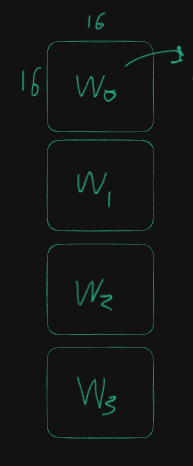

In [ ]:
"""
currently we are at the tiling depicted by the above picture. 
next, we need to tile each (16,16) chunks, 
right now, reading right to left, we have warp_id_in_warpgroup -> its (16,16) chunk 

"""

In [161]:
A_tensor = torch.arange(16*64, dtype=torch_dtype(cutlass.Float16))
A_ptr = cute_rt.make_ptr(cutlass.Float16, A_tensor.data_ptr())
@cute.jit
def warp_tiler(pointer:cute.Pointer):
  element_L = cute.make_layout((16,64), stride = (1,16)) #column major A, we dont really give a fuck though stride is guuci 
  warp_tile = cute.make_layout((16,16), stride=(1,16))
  element_warp_L = cute.zipped_divide(element_L, warp_tile)
  elem_tile_warp_L = cute.zipped_divide(element_warp_L, (cute.make_layout((8,8), stride = (1,8)),))
  new_L = cute.zipped_divide(elem_tile_warp_L, (cute.make_layout((2,)),))
  
  cute.printf(new_L)
  T = cute.make_tensor(pointer,new_L)
  cute.print_tensor(T, verbose=True)
  #we can do many crazy things here, like lets print everything owned by warp0, thread 0 
  cute.print_tensor(T[(((None)),(0,(None,0)))])
  #we can pring everything owned by reister 0 across each thread of warp 0 
  cute.print_tensor(T[(((None)),(None,(0,0)))], verbose = True)

In [163]:
warp_tiler(A_ptr)

(((2)),(32,(4,4))):(((1)),(2,(64,256)))
tensor(raw_ptr(0x0000555691f28080: f16, generic, align<2>) o (((2)),(32,(4,4))):(((1)),(2,(64,256))), data= (
	(((0)),(0,(0,0)))= 0.000000
	(((1)),(0,(0,0)))= 1.000000
	(((0)),(1,(0,0)))= 2.000000
	(((1)),(1,(0,0)))= 3.000000
	(((0)),(2,(0,0)))= 4.000000
	(((1)),(2,(0,0)))= 5.000000
	(((0)),(3,(0,0)))= 6.000000
	(((1)),(3,(0,0)))= 7.000000
	(((0)),(4,(0,0)))= 8.000000
	(((1)),(4,(0,0)))= 9.000000
	(((0)),(5,(0,0)))= 10.000000
	(((1)),(5,(0,0)))= 11.000000
	(((0)),(6,(0,0)))= 12.000000
	(((1)),(6,(0,0)))= 13.000000
	(((0)),(7,(0,0)))= 14.000000
	(((1)),(7,(0,0)))= 15.000000
	(((0)),(8,(0,0)))= 16.000000
	(((1)),(8,(0,0)))= 17.000000
	(((0)),(9,(0,0)))= 18.000000
	(((1)),(9,(0,0)))= 19.000000
	(((0)),(10,(0,0)))= 20.000000
	(((1)),(10,(0,0)))= 21.000000
	(((0)),(11,(0,0)))= 22.000000
	(((1)),(11,(0,0)))= 23.000000
	(((0)),(12,(0,0)))= 24.000000
	(((1)),(12,(0,0)))= 25.000000
	(((0)),(13,(0,0)))= 26.000000
	(((1)),(13,(0,0)))= 27.000000
	(((0)),(14,

In [154]:
print(A_tensor)

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.0210e+03, 1.0220e+03,
        1.0230e+03], dtype=torch.float16)


### The crude layout 

Although we dont know how to use this bad boy cleanly yet, we have the A layout fom m16n16k16 in WGMAA bf16 in some form where the co-ordinate acess looks like 
((bf16x2_vector_id), (lane_id), (register_id(0 to 4)), (warp_in_warpgroup_id[0 to 4]))

-most_contigous/fastest_dim----------slower_dims/lesscontigous----------->>>>>>>>>